<a href="https://colab.research.google.com/github/alpdk/kotlin_internship/blob/main/JB_internship_test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install pacakages

In [ ]:
!pip install accelerate transformers einops
!pip install datasets peft bitsandbytes
!pip install flash_attn gdown
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

Imports

In [ ]:
import os
import json
import torch
import statistics
import numpy as np
import pandas as pd
import Levenshtein as lv

from tqdm import tqdm
from datasets import load_dataset, Dataset
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig


HuggingFace autentification

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Preprocessing dataset

In [ ]:
# This dataset was prepared from github by this link https://github.com/JetBrains/kotlin

!gdown https://drive.google.com/uc?id=12exWwkmYPV5rvzRpNtCHSr9L4_2cVscp

Downloading...
From (original): https://drive.google.com/uc?id=12exWwkmYPV5rvzRpNtCHSr9L4_2cVscp
From (redirected): https://drive.google.com/uc?id=12exWwkmYPV5rvzRpNtCHSr9L4_2cVscp&confirm=t&uuid=8594e49c-32d8-43f3-9016-1b5dd45db536
To: /content/internship_dataset.zip
100% 35.8M/35.8M [00:01<00:00, 21.2MB/s]


In [ ]:
!unzip internship_dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: internship_dataset/memberFunWithoutBodyWithTypeWithoutNameScript.kts  
  inflating: internship_dataset/26.fir.kt  
  inflating: internship_dataset/inlinedObjectLiteralIsCheck.kt  
  inflating: internship_dataset/protectedSuper.kt  
 extracting: internship_dataset/InlineDivision.kt  
  inflating: internship_dataset/localVariableWithSubstitution.kt  
  inflating: internship_dataset/EnclosingEnumerationType.kt  
  inflating: internship_dataset/Labels.kt  
  inflating: internship_dataset/50.fir.kt  
  inflating: internship_dataset/FirErrorsDefaultMessages.kt  
  inflating: internship_dataset/KotlinBrowserJs.kt  
  inflating: internship_dataset/delegateToConstructorParameter.kt  
  inflating: internship_dataset/nullNullOk.kt  
  inflating: internship_dataset/Comparators.kt  
  inflating: internship_dataset/internalObject.kt  
  inflating: internship_dataset/onlyLocalReturnLambda.kt  
  inflating: internship_dat

In [ ]:
# Create dictionary for specific file
def process_kt_file(file_path):
    with open(file_path, 'r') as f:
        text = f.read()

        info = {
            "file_name": os.path.basename(file_path),
            "text": text
        }
        return info

# Create a list of dictionaries for all files from dataset
def convert_to_json(directory_path, output_file):
    kt_files = [f for f in os.listdir(directory_path) if f.endswith('.kt')]
    data = []

    for file_name in tqdm(kt_files):
        file_path = os.path.join(directory_path, file_name)
        data.append(process_kt_file(file_path))

    with open(output_file, 'w') as json_file:
        json.dump(data, json_file, indent=4)


directory_path = 'internship_dataset'

output_file = 'output.json'

convert_to_json(directory_path, output_file)

100%|██████████| 42750/42750 [00:01<00:00, 38801.05it/s]


In [ ]:
json_file_path = 'output.json'

df = pd.read_json(json_file_path)

print(df["text"][0])

// FIR_IDENTICAL
// FILE: a.kt
// KT-26 Import namespaces defined in this file

import html.* // Must not be an error

// FILE: b.kt

package html

abstract class Factory<T: Any> {
fun create() : T? = null
}



In [ ]:
dataset = Dataset.from_dict(df)

In [ ]:
# Install python dataset for check
!curl -X GET "https://datasets-server.huggingface.co/first-rows?dataset=microsoft%2Fcodexglue_method_generation&config=default&split=test" > test_py.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63837  100 63837    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k


In [ ]:
# Install kotlin dataset for check
!curl -X GET "https://datasets-server.huggingface.co/rows?dataset=codkiller0911%2Fkotlin_code&config=default&split=train&offset=0&length=100" > test_kt.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51248  100 51248    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k


In [ ]:
def python_json(test_json):
    res_test = []

    for i in test_json['rows']:
        small_dict = {}

        small_dict['input'] = i['row']['docstring'] + ' ' + i['row']['signature']
        small_dict['output'] = i['row']['body']

        res_test.append(small_dict)

    return res_test

def kotlin_json(test_json):
    res_test = []

    for i in test_json['rows']:
        small_dict = {}

        small_dict['input'] = i['row']['Message']
        small_dict['output'] = i['row']['Code_Function']

        res_test.append(small_dict)

    return res_test


# Transform installed datasets to simpler format
def create_json_dataset(file_name):
    with open(file_name, 'r') as f:
        test_json = json.load(f)

    if 'py' in file_name:
        return python_json(test_json)
        print('py')
    elif 'kt' in file_name:
        return kotlin_json(test_json)
        print('kt')

In [ ]:
dataset_test_kt = create_json_dataset('test_kt.json')
dataset_test_py = create_json_dataset('test_py.json')

End of optional part

Make function for taking Levenshtein distance between model answer and true result

In [ ]:
# Getting result from model
def generate_completion(input_text, model, tokenizer):
    inputs = tokenizer(input_text, return_tensors="pt", return_attention_mask=False).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=60)

    completion = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    return completion

In [ ]:
# Calculate Levenshtein distance between model result and wanted result
def calculate_levenshtein_distance(dataset):
  results_of_dist = []

  for item in tqdm(dataset):
      input_text = item['input']
      expected_output = item['output']

      generated_output = generate_completion(input_text, model, tokenizer)

      results_of_dist.append(lv.distance(generated_output, expected_output) / (len(generated_output) + len(expected_output)))

  return statistics.median(results_of_dist)

Getting LLm from hugging face and start finetunning it

In [ ]:
# Upload tokenizer from microsoft/phi-1_5
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
!pip install accelerate

In [ ]:
# Upload model microsoft/phi-1_5
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-1_5",
    device_map={"":0},
    trust_remote_code=True
)

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

In [ ]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,

In [ ]:
print(dataset_test_kt)

[{'input': 'javax.net.ssl.SSLEngine # unwrap ( ByteBuffer src , ByteBuffer [ ] dsts ) ReadOnlyBufferException should be thrown .', 'output': '@KnownFailure("Fixed on DonutBurger, Wrong Exception thrown") fun`test_unwrap_ByteBuffer$ByteBuffer_02`() { val host = "new host" val port = 8080 val bbs: ByteBuffer = ByteBuffer.allocate(10) val bbR: ByteBuffer = ByteBuffer.allocate(100).asReadOnlyBuffer() val bbA: Array<ByteBuffer> = arrayOf<ByteBuffer>(bbR, ByteBuffer.allocate(10), ByteBuffer.allocate(100)) val sse: SSLEngine = sun.jvm.hotspot.utilities.soql.SOQLEngine.getEngine(host, port) sse.setUseClientMode(true) try { sse.unwrap(bbs, bbA) fail("ReadOnlyBufferException wasn\'t thrown") } catch (iobe: ReadOnlyBufferException) { } catch (e: Exception) { fail("$e was thrown instead of ReadOnlyBufferException") } }'}, {'input': 'Makes an instance for the given value . This may ( but does not necessarily ) return an already-allocated instance .', 'output': 'fun make(bits: Int): CstFloat? { retu

In [ ]:
# Calculate result on python and kotlin test dataset before finetune
not_finetuned_res_py = calculate_levenshtein_distance(dataset_test_py)
not_finetuned_res_kt = calculate_levenshtein_distance(dataset_test_kt)

100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


In [ ]:
print(f"Python: Not finetunde dist: {not_finetuned_res_py}")
print(f"Kotlin: Not finetunde dist: {not_finetuned_res_kt}")

Python: Not finetunde dist: 0.6138158942506768
Kotlin: Not finetunde dist: 0.5569837059492232


In [ ]:
# Setting LoraConfig for phi-1_5
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["dense", "fc2","q_proj","k_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 10,223,616 || all params: 1,428,494,336 || trainable%: 0.7156917421617274


In [ ]:
# Tokenize sample
def tokenize(sample):
    model_inps =  tokenizer(sample["text"], padding=True, truncation=True, max_length=512)
    return model_inps

In [ ]:
# Split kotlin dataset for training on training and testing parts
train, test = train_test_split(df, test_size=0.2, train_size=0.8)

In [ ]:
tokenized_data = dataset.map(tokenize, batched=True, desc="Tokenizing data", remove_columns=dataset.column_names)

Tokenizing data:   0%|          | 0/42750 [00:00<?, ? examples/s]

In [ ]:
# Set training arguments for finetuning
training_arguments = TrainingArguments(
        output_dir="/output/phi-1-5-finetuned-cazton_complete",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=1e-5,
        lr_scheduler_type="linear",
        save_strategy="epoch",
        logging_steps=100,
        max_steps=300,
        num_train_epochs=1,
        push_to_hub=True
    )

In [ ]:
# Create trainer and train model
trainer = Trainer(
    model=model,
    train_dataset=tokenized_data,
    args=training_arguments,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
100,1.699100
200,1.609300
300,1.592400


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TrainOutput(global_step=300, training_loss=1.6335799662272135, metrics={'train_runtime': 495.0888, 'train_samples_per_second': 2.424, 'train_steps_per_second': 0.606, 'total_flos': 4879454463590400.0, 'train_loss': 1.6335799662272135, 'epoch': 0.0280688622754491})

End of training

Checking result

In [ ]:
# Calculate result on python and kotlin test dataset after finetune
finetuned_res_py = calculate_levenshtein_distance(dataset_test_py)
finetuned_res_kt = calculate_levenshtein_distance(dataset_test_kt)

100%|██████████| 100/100 [04:42<00:00,  2.82s/it]


In [ ]:
print(f"Python: Not finetunde dist: {not_finetuned_res_py} Finetunde: {finetuned_res_py}")
print(f"Kotlin: Not finetunde dist: {not_finetuned_res_kt} Finetunde: {finetuned_res_kt}")

Python: Not finetunde dist: 0.6138158942506768 Finetunde: 0.6127431342082108
Kotlin: Not finetunde dist: 0.5569837059492232 Finetunde: 0.5705705402568036


In [ ]:
# epochs 2400
# Python: Not finetunde dist: 0.6138158942506768 Finetunde: 0.6041992372866732
# Kotlin: Not finetunde dist: 0.5569837059492232 Finetunde: 0.5854846182357302

In [ ]:
# epochs 1200
# Python: Not finetunde dist: 0.6138158942506768 Finetunde: 0.6048782957548171
# Kotlin: Not finetunde dist: 0.5569837059492232 Finetunde: 0.5656882192397512

In [ ]:
# epochs 600
# Python: Not finetunde dist: 0.6138158942506768 Finetunde: 0.6023744896710533
# Kotlin: Not finetunde dist: 0.5569837059492232 Finetunde: 0.5752337201805287

In [ ]:
# epochs 300
# Python: Not finetunde dist: 0.6138158942506768 Finetunde: 0.6127431342082108
# Kotlin: Not finetunde dist: 0.5569837059492232 Finetunde: 0.5705705402568036

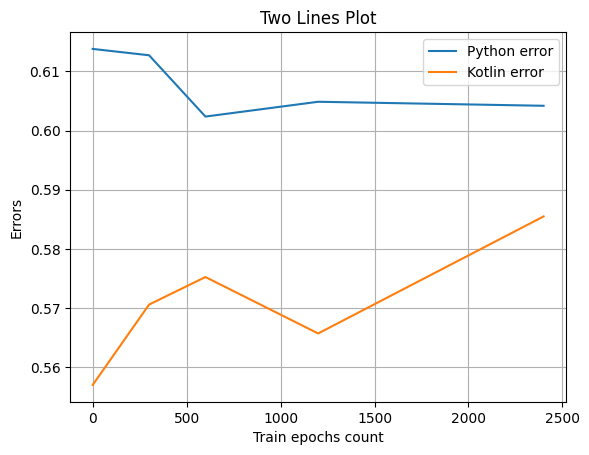

In [1]:
import matplotlib.pyplot as plt

# Sample data
x = [0, 300, 600, 1200, 2400]
y1 = [0.6138158942506768, 0.6127431342082108, 0.6023744896710533, 0.6048782957548171, 0.6041992372866732]
y2 = [0.5569837059492232, 0.5705705402568036, 0.5752337201805287, 0.5656882192397512, 0.5854846182357302]

# Plotting
plt.plot(x, y1, label='Python error')
plt.plot(x, y2, label='Kotlin error')
plt.xlabel('Train epochs count')
plt.ylabel('Errors')
plt.title('Two Lines Plot')
plt.legend()
plt.grid(True)
plt.show()